# Preparacion del entorno

Librerias

In [1]:
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import ipynb.fs     #Para importar desde ipynb
import matplotlib.pyplot as plt

Num GPUs Available:  1


# Preparacion de los datos

In [2]:
from .defs.preparacion_datos import unpickle, tryDataset

(60000, 28, 28, 1)


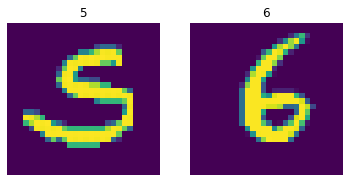

(10000, 28, 28, 1)


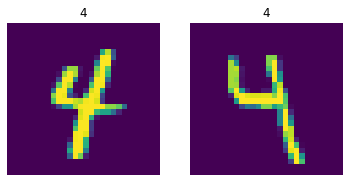

In [3]:
X_train = unpickle("Input\MNIST-train")
X_test = unpickle("Input\MNIST-test")
tryDataset(X_train)
tryDataset(X_test)

# Arquitectura del ``Autoencoder``

In [4]:
from .defs.arquitectura import *

# Entrenamiento

## Persistencia

In [5]:
_raiz = "Resultados/MNISTpruebasAAE"
_nombre = "MNISTpAAE"

Creamos las carpetas para almacenar el output

In [6]:
def mkfolders(ruta, verbose=False):
    try:
        os.makedirs(ruta)
    except OSError:
        if verbose: print("Carpeta %s ya existe" % (ruta))
    

In [7]:
mkfolders(_raiz, True)

Carpeta Resultados/MNISTpruebasAAE ya existe


## Funciones de muestreo

In [8]:
def sample_imgs(dataset, model, epoch, nclases, sample_size=5, save_imgs=True, show=False, ruta=_raiz, nombre="", title=""):
    # Tomamos sample_size imagenes de muestra
    ids = np.random.randint(0,dataset["data"].shape[0], sample_size)
    set={k:v[ids] for k,v in dataset.items()}
    sample = set["data"]
    if nclases > 1:
        model_input=set
        model_input["labels"]=onehotify(model_input["labels"], nclases)
    else:
        model_input=sample
    # Intentamos regenerar las imagenes
    gen_img = model.predict(model_input)[0]
    # Guardamos una grafica con la muestra (arriba) y las imagenes generadas (abajo)
    f, axxs = plt.subplots(2,sample_size)
    if title!="":
        f.suptitle(title+"_"+nombre, fontsize=12)
    for j in range(sample_size):
        axxs[0,j].imshow(sample[j])
        axxs[1,j].imshow(gen_img[j])
    for i in axxs:
        for j in i:
            j.axis("off")
    if save_imgs:
        ruta+="/Output/Regeneracion"
        mkfolders(ruta)
        savefile= ruta+"/"+nombre+"generationCIFAR10_e%d.jpg" % (epoch)
        f.savefig(savefile)
    if show:
        plt.show()
    plt.close()
    

In [9]:
def generate_samples(dim_latente, decoder, epoch, ruta=_raiz, nombre=_nombre, output=True, show=False):
    sample_shape = (5,5)
    latent_samples = true_sampler(dim_latente, np.prod(sample_shape))
    samples=decoder.predict(latent_samples)#*0.5 +0.5
    fig, axxs = plt.subplots(sample_shape[0], sample_shape[1])
    s=0
    for i in range(sample_shape[0]):
        for j in range(sample_shape[1]):
            axxs[i,j].imshow(samples[s])
            axxs[i,j].axis("off")
            s+=1
    if output:
        ruta+="/Output/Progreso"
        mkfolders(ruta)
    fig.savefig(ruta+"\\"+nombre+"progresscifar10_e%d.png" % (epoch))
    if show:
        print("Imagenes generadas desde el espacio latente:")
        plt.show()
    plt.close()

    

In [10]:
from IPython.display import Image
from IPython.display import display
def show_prevResults(ruta, nombre=_nombre, epochs=5000):
    
    x = Image(filename=ruta+'\\Output/Progreso'+"\\"+nombre+"progresscifar10_e%d.png" % (epochs-1))
    print("Imagenes generadas desde el espacio latente:")
    display(x)

    x = Image(filename=ruta+"\\"+nombre+"progresscifar10_plot.jpg")
    print("Historia del entrenamiento:")
    display(x)

    x = Image(filename=ruta+"/Output/Regeneracion/TRAINSETgenerationCIFAR10_e%d.jpg" % (epochs))
    print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):") 
    display(x) 
     
    x = Image(filename=ruta+"/Output/Regeneracion/TESTSETgenerationCIFAR10_e%d.jpg" % (epochs))         
    print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
    display(x)

    #n = np.random.randint(0, 10)
    #x = Image(filename=ruta+"/Output/Latente/GenFromLatentTRAINSET label %d.jpg" % (n))         
    #print("Imagenes generadas desde el punto medio entre coordenadas latentes de dos imagenes (TrainSet):")
    #display(x)
    
    #x = Image(filename=ruta+"/Output/Latente/GenFromLatentTESTSET label %d.jpg" % (n))         
    #print("Imagenes generadas desde el punto medio entre coordenadas latentes de dos imagenes (TestSet):")
    #display(x)
    

In [11]:
def exploraLatente(encoder, decoder, groupPath, ruta=_raiz, nombre=_nombre):
    groups = unpickle(groupPath)
    ruta+="/Output/Latente"
    mkfolders(ruta)
    for key in groups.keys():
        imgs = groups[key]
        latent = []
        size = len(imgs)
        # Obtencion de coordenadas en espacio latente
        #for i in range(size):
        pred = encoder.predict(imgs)
        latent = pred
            #latent.append(pred)
        # Obtenemos la coordenada intermedia
        latent = tf.math.divide(tf.math.add_n(latent),size)
        latent = np.array([latent])
        #Generamos la imagen de esa coordenada
        generated = decoder.predict(latent)

        f, axxs = plt.subplots(1,size+1)
        f.suptitle("Latent aproximation for class "+str(key)+" from " + groupPath, fontsize=12)
        for j in range(size):
            axxs[j].imshow(imgs[j])
            axxs[j].axis("off")
            axxs[j].set_title("Real")
        axxs[size].imshow(generated[0])
        axxs[size].axis("off")
        axxs[size].set_title("Generated")
        plt.show()
        plt.close()
        
        f.savefig(ruta+"\\"+nombre+" label %d.jpg" % (key))

In [12]:
def plotlatent2D(encoder, dataset, ruta=_raiz, nombre=_nombre):
    ruta+="/Output/Latente"
    mkfolders(ruta)
    points = encoder.predict(dataset["data"])

    x = np.array(list(x for (x,_) in points))
    y = np.array(list(y for (_,y) in points))
    colors = dataset["labels"]

    plt.scatter(x, y, c=colors, cmap='hsv')

    plt.colorbar()
    fig = plt.gcf()
    plt.show()
    fig.savefig(ruta+"\\"+nombre+"_space.jpg")
    plt.close()

## Generacion de ejemplos (positivos y negativos)

In [13]:
def true_sampler(dim_latente, batch_size):
    return np.random.normal(size=(batch_size, dim_latente))

In [14]:
true_sampler(3, 2)

array([[ 0.41419102, -0.11825378, -0.01431269],
       [-1.72281998, -0.90525505, -1.1622208 ]])

In [15]:
def onehotify(labels, nclases):
    onehotlabels = []
    for label in labels:
        thisLabel = np.zeros(nclases)
        thisLabel[label]=1
        onehotlabels.append(thisLabel)
    return np.array(onehotlabels)

In [16]:
def true_sampler_clases(dim_latente, batch_size, nclases):
    samples = []
    sigma = 1/nclases
    clases = np.random.randint(0, nclases, batch_size)
    clases1hot= onehotify(clases, nclases)
    for clase in clases:        
        mu = clase*sigma+(0.5*sigma)
        s = np.random.normal(loc = mu, scale=sigma, size=dim_latente)
        samples.append(s)
    return np.array(samples), clases1hot

In [17]:
def generateRandomVectors(dim_latente, batch_size, nclases):
    vectors = []
    labels = np.zeros((batch_size, nclases))
    
    for label in labels:
        l = np.random.randint(0, nclases)
        label[l] = 1
        mean = [10*np.cos((l*2*np.pi)/10), 10*np.sin((l*2*np.pi)/10)]
        v1 = [np.cos((l*2*np.pi)/10), np.sin((l*2*np.pi)/10)]
        v2 = [-np.sin((l*2*np.pi)/10), np.cos((l*2*np.pi)/10)]
        a1 = 8
        a2 = .4
        M =np.vstack((v1,v2)).T
        S = np.array([[a1, 0], [0, a2]])
        cov = np.dot(np.dot(M, S), np.linalg.inv(M))
        #cov = cov*cov.T
        vec = np.random.multivariate_normal(mean=mean, cov=cov,
                                            size=1)
        vectors.append(vec)
    return (np.array(vectors).reshape(-1, 2), labels)

In [18]:
true_sampler_clases(2,2,10)

(array([[0.66749569, 0.86866143],
        [0.21665014, 0.25781809]]),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [19]:
def fake_sampler(imgs, encoder):
    latent_fake = encoder.predict(imgs["data"])
    return latent_fake

In [20]:
def fake_class_sampler(imgs, encoder, nclases):
    latent_fake = encoder.predict(imgs["data"])
    labels = onehotify(imgs["labels"], nclases)
    return latent_fake, labels

## Grafica de progreso

In [21]:
def plot_history(history, ruta=_raiz, nombre=_nombre, title=""):
    disc_loss = history[0]
    disc_acc  = history[1]
    aac_loss1 = history[2]
    aac_loss2 = history[3]

    fig, axxs = plt.subplots(1,3)
    if title != "":
        fig.suptitle(title, fontsize=16)

    fig.set_figwidth(24)
    fig.set_figheight(6)

    axxs[0].set_title("Discriminator")
    axxs[1].set_title("Discriminator")
    axxs[2].set_title("AdversarialAutoencoder")

    axxs[0].set_xlabel("Epoch")
    axxs[1].set_xlabel("Epoch")
    axxs[2].set_xlabel("Epoch")

    axxs[0].plot(disc_loss, label = "Loss")
    axxs[1].plot(disc_acc, label = "Accuracy")

    axxs[2].plot(aac_loss1, label = "Loss_decoder")
    axxs[2].plot(aac_loss2, label = "Loss_discriminator")

    axxs[0].legend()
    axxs[1].legend()
    axxs[2].legend()

    fig.savefig(ruta+"\\"+nombre+"progresscifar10_plot.jpg")
    plt.show()
    plt.close()

## Funcion de entrenamiento

In [22]:
def fit_AAE(dim_latente, aae, epochs=12, batch_size=100, sample_interval=100, ruta=_raiz, nombre=_nombre, verbose=True,
            truth=true_sampler, truth_kwargs={}, falsehood=fake_sampler):
    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(50000, seed=2022)
    dataset = dataset.batch(batch_size)

    history = np.empty([0,4])

    encoder, decoder, discriminator, a_autoencoder=aae
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    truth_params = {"dim_latente":dim_latente, "batch_size":batch_size}
    truth_params.update(truth_kwargs)

    for epoch in range(epochs):
        print("EPOCH %d" % (epoch))
        for step, imgs in enumerate(dataset):
            falsehood_params = {"imgs":imgs, "encoder":encoder}
            falsehood_params.update(truth_kwargs)
            #Espacios latentes "reales" y "falsos" para el discriminador
            latent_fake = falsehood(**falsehood_params)
            latent_true = truth(**truth_params)

            #entrenamos el discriminador
            dis_loss_real = discriminator.train_on_batch(latent_true, valid)
            dis_loss_fake = discriminator.train_on_batch(latent_fake, fake)
            dis_avg_loss = 0.5*np.add(dis_loss_fake, dis_loss_real)

            # entrenamos al autoencoder
            if "nclases" in truth_kwargs:
                imgs["labels"]=onehotify(imgs["labels"], truth_kwargs["nclases"])
            aae_loss = a_autoencoder.train_on_batch(imgs,[imgs["data"], valid]) # El resultado debe ser la imagen sin las etiquetas
            
            # Guardamos el progreso
            history = np.append(history, [np.append(dis_avg_loss[:2], aae_loss[:2])], axis=0)
            
            # monitorizamos el progreso
            if ((step+1) % sample_interval)==0 and verbose:
                print("Epoch: %d Step: %d Disc: (loss = %f, acc = %.2f%%) AAE: (mse = %f, b_ce = %f)" % (epoch, step, dis_avg_loss[0], 100*dis_avg_loss[1], aae_loss[0], aae_loss[1]))
            # Hacemos una muestra visual
        generate_samples(dim_latente, decoder, epoch, ruta=ruta, nombre=nombre, show=((epoch+1)==epochs))
    return history.transpose(1,0)

## Entrenamiento en grid

Tamaño de la capa latente:

In [23]:
dim_latente_cand = [2]

Tamaño de las imagenes:

In [24]:
img_shape = X_train["data"][0].shape

Parametros:

In [25]:
encoders = [(build_dense_encoder, "dense_enc"), (build_transf_encoder,"transf_enc"), (build_conv_encoder,"conv_enc")]

decoders = [(build_dense_decoder,"dense_dec"), (build_conv_decoder,"conv_dec")]

discriminators = [(build_discriminator ,"default_disc", {}, {"truth":true_sampler, "truth_kwargs":{}, "falsehood":fake_sampler}),
                    (build_class_discriminator2 ,"class_disc",{"clases":10}, {"truth":generateRandomVectors, "truth_kwargs":{"nclases":10}, "falsehood":fake_class_sampler})]


ae_losses = [(losses.mean_squared_error, "ae_MSE_loss")]
disc_losses =[(losses.binary_crossentropy, "disc_binXentropy_loss")]

In [26]:
#dim_latente_cand = [64]                         # para que las pruebas no tarden 2 horas
#dim_latente_cand = [64, 256, 1024]              # para que las pruebas no tarden 7 horas
#decoders = [(build_dense_decoder,"dense_dec")]  # para que las pruebas no tarden 2 horas

In [27]:
epochs = 12

In [28]:
def mainLoop(model_name="MODEL", enc= (build_dense_encoder, "dense_enc"), dec = (build_dense_decoder,"dense_dec")):
    for ae_loss in ae_losses:
        for disc in discriminators:
            for disc_loss in disc_losses:
                for dim_latente in dim_latente_cand:
                    ruta = _raiz+"\\"+model_name+"\\"+ae_loss[1]+"\\"+disc[1]+"\\"+disc_loss[1]+"\\"+str(dim_latente)
                    if os.path.isfile(ruta+"/Modelos\\decoder.h5") or os.path.isfile(ruta+"/Modelos\\autoencoder.h5"):
                        print(ruta+" ya ha sido entrenada")
                        show_prevResults(ruta, epochs=epochs)
                        continue
                    mkfolders(ruta, True)
                    ck = {"ae_loss": ae_loss[0], "disc_loss":disc_loss[0]}
                    aae = assemble_AAE(dim_latente, img_shape, enc_model = enc[0], dec_model = dec[0], disc_model = disc[0], 
                                    compilation_kwargs=ck, disc_kwargs=disc[2])
                    fit_settings = {"dim_latente":dim_latente, "aae":aae, "epochs":epochs, "ruta" : ruta}
                    fit_settings.update(disc[3])
                    history = fit_AAE(**fit_settings)
                    print("Historia del entrenamiento:")
                    plot_history(history, ruta=ruta, title=ruta)
                    (encoder, decoder, _, autoencoder) = aae
                    print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):")
                    clases=0
                    if "clases" in disc[2].keys():
                        clases=disc[2]["clases"]
                    sample_imgs(X_train, autoencoder, epoch=epochs, nclases=clases, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TRAINSET")
                    print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
                    sample_imgs(X_test, autoencoder, epoch=epochs, nclases=clases, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TESTSET")
                    #print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):")
                    #exploraLatente(encoder, decoder, "Input\cifar-10-groupedtrain", ruta=ruta, nombre="GenFromLatentTRAINSET")
                    #print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):")
                    #exploraLatente(encoder, decoder, "Input\cifar-10-groupedtest", ruta=ruta, nombre="GenFromLatentTESTSET")
                    print("Representacion del espacio latente 2D:")
                    plotlatent2D(encoder, X_test, ruta=ruta, nombre="TESTSET")
                    mkfolders(ruta+"/Modelos")
                    #decoder.save(ruta+"/Modelos\\decoder.h5")
                    #autoencoder.save(ruta+"/Modelos\\autoencoder.h5")


### Entrenamiento de AAE Denso

Carpeta Resultados/MNISTpruebasAAE\DENSE\ae_MSE_loss\default_disc\disc_binXentropy_loss\2 ya existe
EPOCH 0


C:\Users\bitde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['labels'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch: 0 Step: 99 Disc: (loss = 0.757834, acc = 54.50%) AAE: (mse = 0.708891, b_ce = 0.066321)
Epoch: 0 Step: 199 Disc: (loss = 0.693850, acc = 46.00%) AAE: (mse = 0.767513, b_ce = 0.057892)
Epoch: 0 Step: 299 Disc: (loss = 0.694309, acc = 50.00%) AAE: (mse = 0.759070, b_ce = 0.056444)
Epoch: 0 Step: 399 Disc: (loss = 0.693755, acc = 50.50%) AAE: (mse = 0.756919, b_ce = 0.055839)
Epoch: 0 Step: 499 Disc: (loss = 0.693904, acc = 50.50%) AAE: (mse = 0.752496, b_ce = 0.052896)
Epoch: 0 Step: 599 Disc: (loss = 0.693708, acc = 49.00%) AAE: (mse = 0.750940, b_ce = 0.052539)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 0.693956, acc = 48.00%) AAE: (mse = 0.751187, b_ce = 0.052857)
Epoch: 1 Step: 199 Disc: (loss = 0.693329, acc = 47.50%) AAE: (mse = 0.751417, b_ce = 0.052787)
Epoch: 1 Step: 299 Disc: (loss = 0.693074, acc = 49.00%) AAE: (mse = 0.753255, b_ce = 0.049514)
Epoch: 1 Step: 399 Disc: (loss = 0.693471, acc = 50.00%) AAE: (mse = 0.747415, b_ce = 0.049861)
Epoch: 1 Step: 499 Disc: (loss = 0

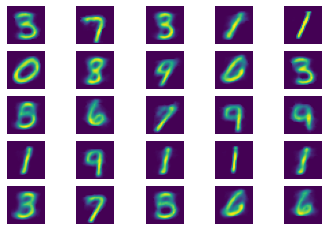

Historia del entrenamiento:


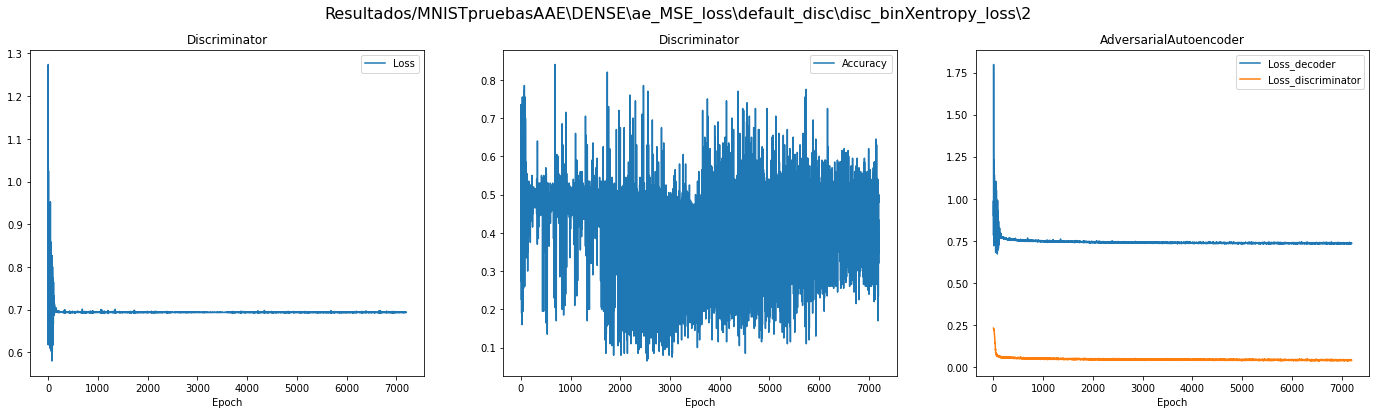

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


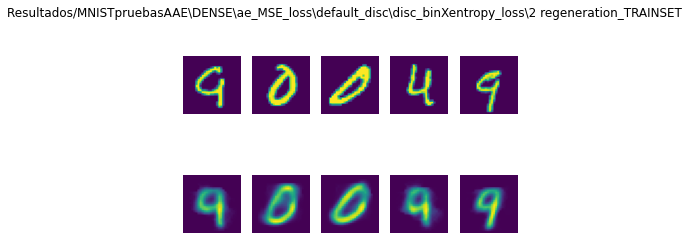

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


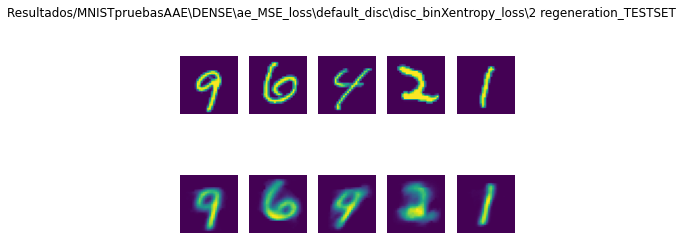

Representacion del espacio latente 2D:


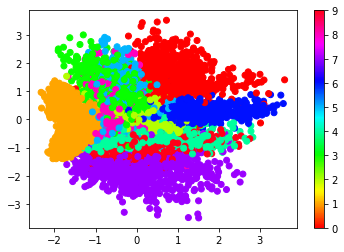

Carpeta Resultados/MNISTpruebasAAE\DENSE\ae_MSE_loss\class_disc\disc_binXentropy_loss\2 ya existe
EPOCH 0


TypeError: Cannot interpret '10' as a data type

In [29]:
enc = (build_dense_encoder2, "dense_enc")
dec = (build_dense_decoder2,"dense_dec")
model_name = "DENSE"

mainLoop(enc=enc, dec=dec, model_name=model_name)


Carpeta Resultados/MNISTpruebasAAE\CONVOLUTIONAL\ae_MSE_loss\default_disc\disc_binXentropy_loss\2 ya existe
EPOCH 0


C:\Users\bitde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['labels'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch: 0 Step: 99 Disc: (loss = 0.621041, acc = 62.50%) AAE: (mse = 1.028921, b_ce = 0.074609)
Epoch: 0 Step: 199 Disc: (loss = 0.693905, acc = 50.00%) AAE: (mse = 0.772751, b_ce = 0.060859)
Epoch: 0 Step: 299 Disc: (loss = 0.699639, acc = 35.00%) AAE: (mse = 0.755673, b_ce = 0.059173)
Epoch: 0 Step: 399 Disc: (loss = 0.696274, acc = 42.50%) AAE: (mse = 0.757132, b_ce = 0.060885)
Epoch: 0 Step: 499 Disc: (loss = 0.692106, acc = 54.50%) AAE: (mse = 0.767463, b_ce = 0.060130)
Epoch: 0 Step: 599 Disc: (loss = 0.695132, acc = 28.50%) AAE: (mse = 0.758226, b_ce = 0.059780)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 0.695265, acc = 48.50%) AAE: (mse = 0.758248, b_ce = 0.059831)
Epoch: 1 Step: 199 Disc: (loss = 0.693987, acc = 49.00%) AAE: (mse = 0.760861, b_ce = 0.062666)
Epoch: 1 Step: 299 Disc: (loss = 0.695328, acc = 35.00%) AAE: (mse = 0.757265, b_ce = 0.059125)
Epoch: 1 Step: 399 Disc: (loss = 0.694573, acc = 46.00%) AAE: (mse = 0.756230, b_ce = 0.059616)
Epoch: 1 Step: 499 Disc: (loss = 0

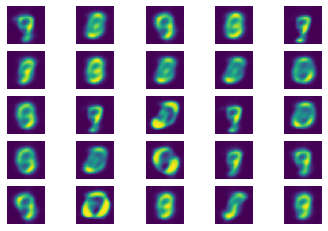

Historia del entrenamiento:


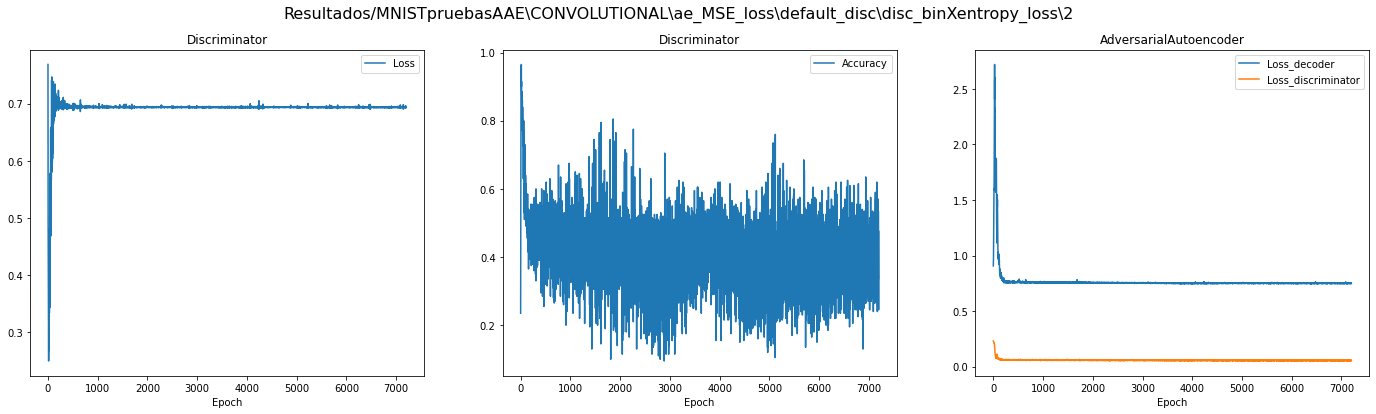

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


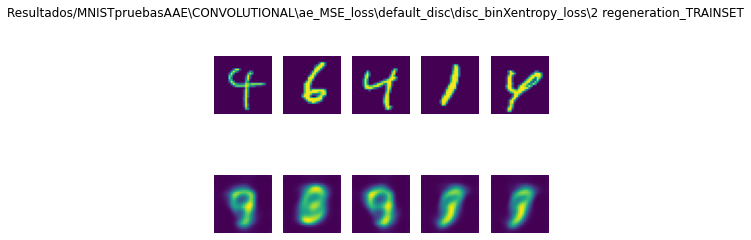

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


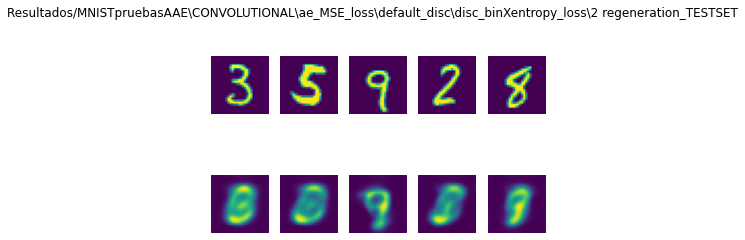

Representacion del espacio latente 2D:


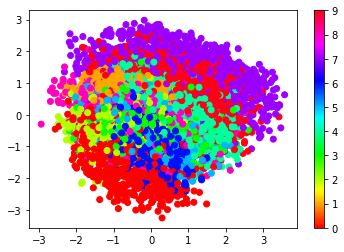

Carpeta Resultados/MNISTpruebasAAE\CONVOLUTIONAL\ae_MSE_loss\class_disc\disc_binXentropy_loss\2 ya existe
EPOCH 0
Epoch: 0 Step: 99 Disc: (loss = 0.806045, acc = 36.00%) AAE: (mse = 1.096675, b_ce = 0.073127)
Epoch: 0 Step: 199 Disc: (loss = 0.781698, acc = 25.00%) AAE: (mse = 0.915365, b_ce = 0.062355)
Epoch: 0 Step: 299 Disc: (loss = 0.754524, acc = 20.50%) AAE: (mse = 0.862716, b_ce = 0.061633)
Epoch: 0 Step: 399 Disc: (loss = 0.734371, acc = 38.00%) AAE: (mse = 0.850328, b_ce = 0.062704)
Epoch: 0 Step: 499 Disc: (loss = 0.738732, acc = 26.00%) AAE: (mse = 0.837549, b_ce = 0.059742)
Epoch: 0 Step: 599 Disc: (loss = 0.730310, acc = 35.00%) AAE: (mse = 0.838004, b_ce = 0.059307)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 0.725815, acc = 15.00%) AAE: (mse = 0.830624, b_ce = 0.061081)
Epoch: 1 Step: 199 Disc: (loss = 0.730684, acc = 18.50%) AAE: (mse = 0.819241, b_ce = 0.061612)
Epoch: 1 Step: 299 Disc: (loss = 0.717803, acc = 40.50%) AAE: (mse = 0.841768, b_ce = 0.059003)
Epoch: 1 Step: 3

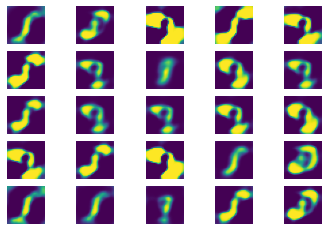

Historia del entrenamiento:


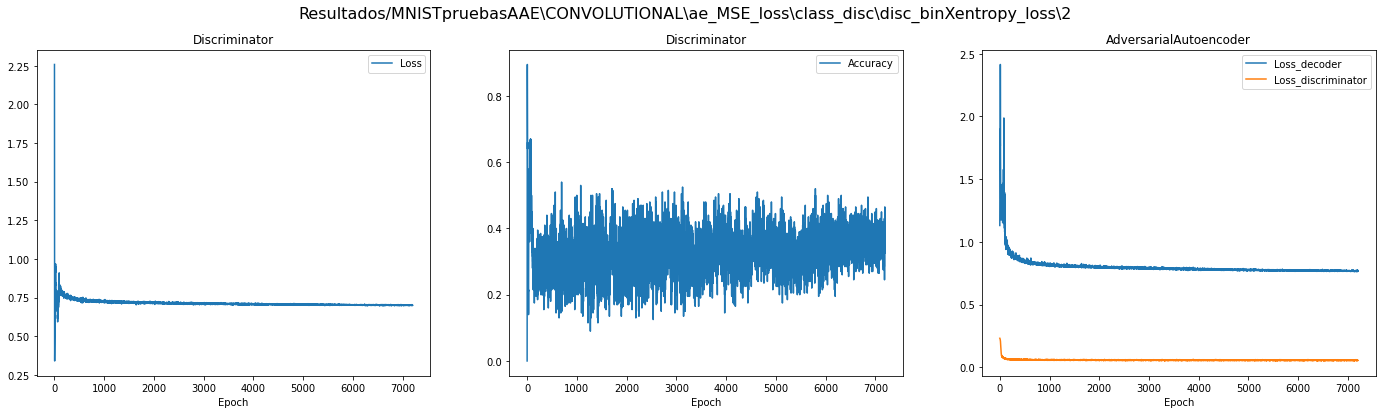

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


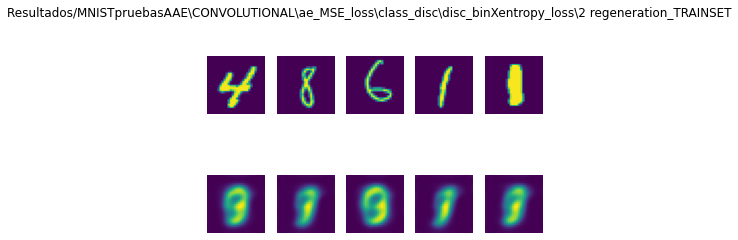

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


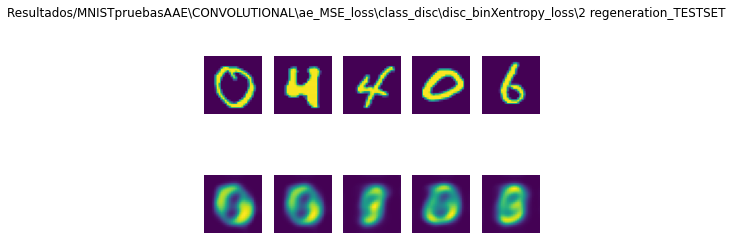

Representacion del espacio latente 2D:


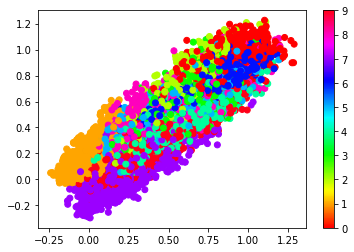

In [ ]:
enc = (build_conv_encoder, "conv_enc")
dec = (build_conv_decoder,"conv_dec")
model_name = "CONVOLUTIONAL"

mainLoop(enc=enc, dec=dec, model_name=model_name)

In [ ]:
# Movnet necesita 3 canales, MNIST tiene solo 1
#enc = (build_transf_encoder, "transf_enc")
#dec = (build_conv_decoder,"conv_dec")
#model_name = "TRANSF_MOVNET"

#mainLoop(enc=enc, dec=dec, model_name=model_name)